In [1]:
## instalar librerias para tvm
!pip install apache-tvm --pre
!pip install typing_extensions
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tvm
from tvm import relay
from tvm.runtime.vm import VirtualMachine

import numpy as np
import cv2

# PyTorch imports
import torch
from torch import nn
import torchvision

In [3]:
in_size = 640
input_shape = (in_size, in_size)

# Load pre-trained yolov5n from yolort and do tracing

In [4]:
!pip install yolort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from yolort.models import yolov5n
from yolort.relay import get_trace_module

In [6]:
model_func = yolov5n(pretrained=True, size=(in_size, in_size))
script_module = get_trace_module(model_func, input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/yolort/models/yolov5.py:145: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for img in inputs:
/usr/local/lib/python3.10/dist-packages/yolort/models/transform.py:179: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  images = [img for img in images]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3912: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.flo

In [7]:
script_module.graph

graph(%self.1 : __torch__.yolort.relay.trace_wrapper.TraceWrapper,
      %x : Float(1, 3, 640, 640, strides=[1228800, 409600, 640, 1], requires_grad=0, device=cpu)):
  %model : __torch__.yolort.models.yolov5.YOLOv5 = prim::GetAttr[name="model"](%self.1)
  %4978 : (Tensor, Tensor, Tensor) = prim::CallMethod[name="forward"](%model, %x)
  %4975 : Float(0, 4, strides=[4, 1], requires_grad=0, device=cpu), %4976 : Float(0, strides=[1], requires_grad=0, device=cpu), %4977 : Long(0, strides=[1], requires_grad=0, device=cpu) = prim::TupleUnpack(%4978)
  %3756 : (Float(0, 4, strides=[4, 1], requires_grad=0, device=cpu), Float(0, strides=[1], requires_grad=0, device=cpu), Long(0, strides=[1], requires_grad=0, device=cpu)) = prim::TupleConstruct(%4975, %4976, %4977)
  return (%3756)

# Download a test image and pre-process

In [8]:
from yolort.utils import get_image_from_url

img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
#img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
frame = get_image_from_url(img_source)

In [9]:
from google.colab.patches import cv2_imshow

In [10]:
frame = frame.astype("float32")
frame = cv2.resize(frame, (in_size, in_size))

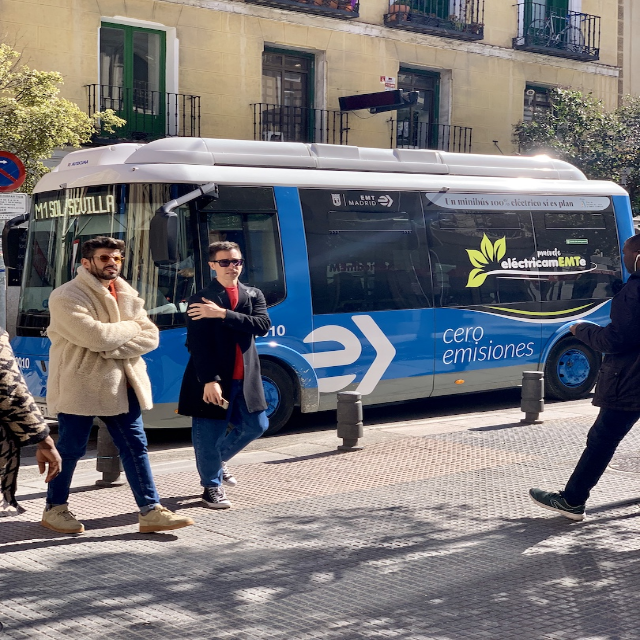

In [11]:
cv2_imshow(frame)

In [12]:
img = np.transpose(frame / 255.0, [2, 0, 1])
img = np.expand_dims(img, axis=0)

# Import the graph to Relay

In [13]:
input_name = "input0"
shape_list = [(input_name, (1, 3, *input_shape))]
mod, params = relay.frontend.from_pytorch(script_module, shape_list)

# Compile with Relay VM

In [14]:
# Add "-libs=mkl" to get best performance on x86 target.
# For x86 machine supports AVX512, the complete target is
# "llvm -mcpu=skylake-avx512 -libs=mkl"
target = "llvm"

with tvm.transform.PassContext(opt_level=3):
    vm_exec = relay.vm.compile(mod, target=target, params=params)

# Inference with Relay VM

In [15]:
ctx = tvm.cpu()
vm = VirtualMachine(vm_exec, ctx)
vm.set_input("main", **{input_name: img})
tvm_res = vm.run()

In [16]:
%%timeit
vm.set_input("main", **{input_name: img})
tvm_res = vm.run()

533 ms ± 72.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Get boxes with score larger than 0.6

In [17]:
score_threshold = 0.6
boxes = tvm_res[0].asnumpy().tolist()
valid_boxes = []
for i, score in enumerate(tvm_res[1].asnumpy().tolist()):
    if score > score_threshold:
        valid_boxes.append(boxes[i])
    else:
        break

print(f"Get {len(valid_boxes)} valid boxes") 

Get 4 valid boxes


In [18]:
np.array(valid_boxes).astype("int")

array([[176, 237, 274, 511],
       [ 42, 233, 169, 537],
       [539, 240, 639, 516],
       [  0, 332,  50, 517]])

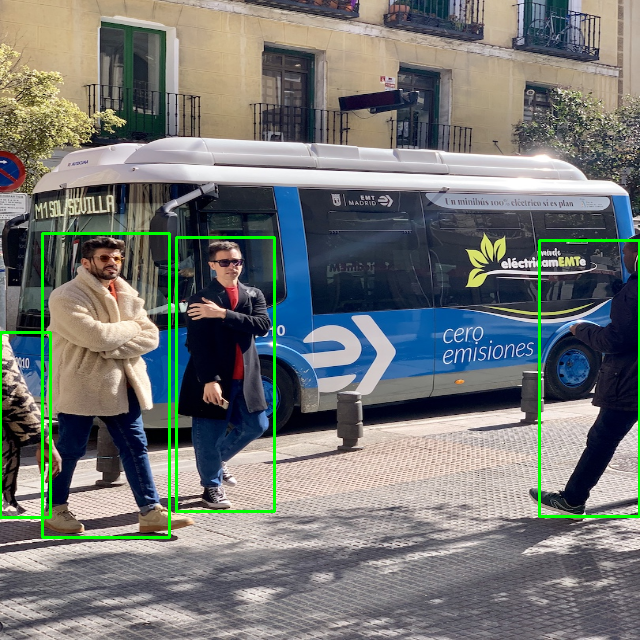

In [19]:
for box in np.array(valid_boxes).astype("int"):
    x,y,xmax,ymax = box
    cv2.rectangle(frame, (x, y), (xmax, ymax), (0,255,0), 2)
cv2_imshow(frame)

# Verify the Inference Output on TVM backend

In [20]:
with torch.no_grad():
    torch_res = script_module(torch.from_numpy(img))

In [21]:
for i in range(len(torch_res)):
    torch.testing.assert_allclose(torch_res[i], tvm_res[i].asnumpy(), rtol=1e-4, atol=1e-4)

print("Exported model has been tested with TVM Runtime, and the result looks good!")

Exported model has been tested with TVM Runtime, and the result looks good!


<ipython-input-21-4586786f6c47>:2: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(torch_res[i], tvm_res[i].asnumpy(), rtol=1e-4, atol=1e-4)
